# Lab 4: Urban Heat Island Detection using Thermal Satellite Imagery

## Goal
In this exercise, you will:
1. Select and compare two thermal satellite images from Kraków (or another city that has recently undergone intensive, thoughtless concrete development) – one from **2013** and one from **2024**.
2. Each image must be acquired on a **hot summer day** (T > 27°C based on IMGW meteorological data).
3. Images must have **low cloud cover** (< 20%).
4. Visualize thermal data and analyze surface temperature differences (Urban Heat Island effect).

## Task 1: Area of Interest (AOI)
- Define an AOI over the Reduta Street area in Kraków.
- Use `ee.Geometry.Polygon` or `ee.Geometry.Rectangle`.

In [ ]:
import ee
ee.Authenticate()
ee.Initialize(project='ee-piotrkrajewski')

aoi = ee.Geometry.Rectangle([21.775851, 49.865839, 21.805091, 49.877559])  # Example coordinates for strzyzow
print(aoi.getInfo())


{'type': 'Polygon', 'coordinates': [[[21.375851, 49.765839], [21.905091, 49.765839], [21.905091, 49.977559], [21.375851, 49.977559], [21.375851, 49.765839]]]}


## Task 2: Download and Analyze IMGW Meteorological Data
- Visit: [IMGW Archive](https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/)
- Navigate to:
  - `dane_meteorologiczne/dobowe/synop/2013/`
  - `dane_meteorologiczne/dobowe/synop/2024/`
- Download `s_d_tmax.csv` for both years.
- Filter the rows for **station ID 12566 (e.g. Kraków-Balice)**.
- Identify days in **July or August** with **TMAX > 27°C**.

Note: you may need to restart the kernel to use updated packages.

2013: 0 days with TMAX > 27°C
Empty DataFrame
Columns: [Date, TMAX]
Index: []

2024: 21 days with TMAX > 27°C
          Date  TMAX
775 2024-07-01  29.3
780 2024-07-06  29.3
781 2024-07-07  32.3
783 2024-07-09  30.3
784 2024-07-10  32.3
785 2024-07-11  34.3
786 2024-07-12  32.8
787 2024-07-13  35.9
788 2024-07-14  28.3
789 2024-07-15  29.8
790 2024-07-16  33.3
791 2024-07-17  29.3
792 2024-07-18  27.8
793 2024-07-19  27.3
794 2024-07-20  28.3
795 2024-07-21  27.8
796 2024-07-22  30.3
798 2024-07-24  27.3
801 2024-07-27  28.3
802 2024-07-28  28.3
805 2024-07-31  27.3


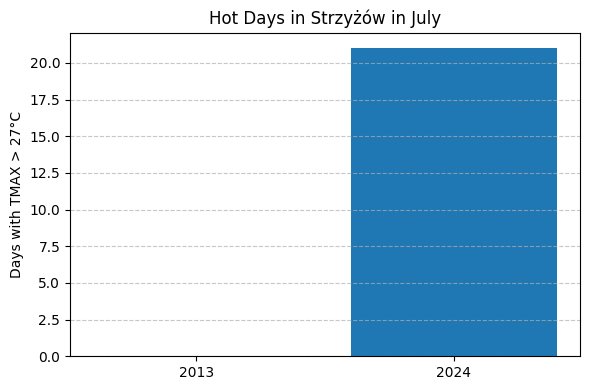

In [47]:
%pip install fsspec
import pandas as pd
import matplotlib.pyplot as plt

# File paths
excel_2013 = "C:/Users/Piotrek/Desktop/Studia/SPACE TECHNOLOGIES/RSAIAIST - Remote Sensing and Image Analysis in Space Tech/labsgit/notebooks/labs4/k_d_t_07_2013.csv"
excel_2024 = "C:/Users/Piotrek/Desktop/Studia/SPACE TECHNOLOGIES/RSAIAIST - Remote Sensing and Image Analysis in Space Tech/labsgit/notebooks/labs4/k_d_07_2024.csv"

STRZYZOW_ID = 250240010


def load_and_filter(file_path):
    df = pd.read_csv(file_path, header=None, encoding='latin1', sep=',')
    filtered = df[
        (df[0] == STRZYZOW_ID) &
        (df[5] > 27)
    ]
    filtered = filtered[[2, 3, 4, 5]]
    filtered.columns = ['Year', 'Month', 'Day', 'TMAX']
    filtered['Date'] = pd.to_datetime(filtered[['Year', 'Month', 'Day']])
    return filtered

hot_2013 = load_and_filter(excel_2013)
hot_2024 = load_and_filter(excel_2024)

print(f"\n2013: {len(hot_2013)} days with TMAX > 27°C")
print(hot_2013[['Date', 'TMAX']])

print(f"\n2024: {len(hot_2024)} days with TMAX > 27°C")
print(hot_2024[['Date', 'TMAX']])

plt.figure(figsize=(6, 4))
plt.bar(['2013', '2024'], [len(hot_2013), len(hot_2024)])
plt.ylabel('Days with TMAX > 27°C')
plt.title('Hot Days in Strzyżów in July')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Task 3: Select Landsat 8 Images Matching These Dates
- In Earth Engine, use `LANDSAT/LC08/C02/T1_L2` collection.
- Apply filters:
  - `.filterBounds(aoi)`
  - `.filterDate()` for the matching day
  - `.filterMetadata('CLOUD_COVER', 'less_than', 20)`
- Try to find **one image from 2013** and **one image from 2024** that match your hot days list.

In [48]:
import geemap 
start_2013 = ee.Date('2013-07-24') 
end_2013 = ee.Date('2013-07-25')
start_2024 = ee.Date('2024-07-30') # one week of difference
end_2024 = ee.Date('2024-07-31')

image_2013 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterBounds(aoi).filterDate(start_2013, end_2013).filterMetadata('CLOUD_COVER', 'less_than', 20).first()
image_2024 = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2').filterBounds(aoi).filterDate(start_2024, end_2024).filterMetadata('CLOUD_COVER', 'less_than', 20).first()
image_2013 = image_2013.clip(aoi)
image_2024 = image_2024.clip(aoi)


vis_params = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
    'min': 5000,
    'max': 15000,
    'gamma': 1.3
}
center = aoi.centroid(10).coordinates().reverse().getInfo()

Map = geemap.Map(center=center, zoom=15)

Map.addLayer(image_2013, vis_params, 'Landsat 2013-07-24')
Map.addLayer(image_2024, vis_params, '2024-07-30')

Map



Map(center=[49.871922783132604, 21.640471000000115], controls=(WidgetControl(options=['position', 'transparent…

## Task 4: Process Thermal Band (ST_B10)
- Convert Band 10 to Brightness Temperature (Kelvin):
  `TB = ST_B10 * 0.00341802 + 149.0`
- Create a visualization of each image using the same color scale.

In [ ]:

bt_2013 = image_2013.select('ST_B10').multiply(0.00341802).add(149.0)
bt_2024 = image_2024.select('ST_B10').multiply(0.00341802).add(149.0)


thermal_vis = {
    'min': 290,
    'max': 320,
    'palette': ['blue', 'green',  'red']
}

center = aoi.centroid(10).coordinates().reverse().getInfo()
Map = geemap.Map(center=center, zoom=15)
Map.addLayer(bt_2013, thermal_vis, '2013 Brightness Temp')
Map.addLayer(bt_2024, thermal_vis, '2024 Brightness Temp')
Map
#i can see that in 2013 there was no clouds above this area, and thats why we get smaller temp in 2024 - because we are looking at cloud directly

Map(center=[49.87169968218406, 21.790470999989275], controls=(WidgetControl(options=['position', 'transparent_…

## Task 5: Compare and Interpret
- Compare the two maps.
- Optionally calculate difference: `TB_2024 - TB_2013`
- Discuss: did the surface temperature increase in the area?
- Is there evidence of an Urban Heat Island effect related to development?

In [ ]:
bt_diff = bt_2024.subtract(bt_2013)

diff_vis = {
    'min': -5,
    'max': 5,
    'palette': ['blue', 'white', 'red']  # Blue = cooler in 2024, Red = hotter in 2024
}



mean_2013 = bt_2013.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).getInfo()

mean_2024 = bt_2024.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).getInfo()

mean_diff = bt_diff.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=aoi,
    scale=30,
    maxPixels=1e9
).getInfo()

print("Average Brightness Temperature 2013 (K):", mean_2013)
print("Average Brightness Temperature 2024 (K):", mean_2024)
print("Difference (K):", mean_diff)


center = aoi.centroid(10).coordinates().reverse().getInfo()
Map = geemap.Map(center=center, zoom=15)


Map.addLayer(bt_diff, diff_vis, 'Temperature Difference (2024 - 2013)')


Map
#same story with these clouds :( (even despite filtering)

Average Brightness Temperature 2013 (K): {'ST_B10': 304.8946411027175}
Average Brightness Temperature 2024 (K): {'ST_B10': 297.80753862195246}
Difference (K): {'ST_B10': -7.087102480765286}


Map(center=[49.87169968218406, 21.790470999989275], controls=(WidgetControl(options=['position', 'transparent_…